_Version log: Branch of V19. Parameter scan accross number of pixels._

In [176]:
import sys, warnings
import numpy as np
import CS_functions as cs
from sklearn.linear_model import Lasso #I'm using scikit insted of svxpy to solve.
from sklearn.exceptions import ConvergenceWarning
from matplotlib import ticker as ticker, pyplot as plt
from scipy import fft as spfft, interpolate as spinter
from tqdm import tqdm
warnings.filterwarnings("ignore", category= ConvergenceWarning)
plt.rcParams.update({'font.size':16})
#np.set_printoptions(threshold=sys.maxsize)

In [177]:
def interpolate(y, new_number_of_points):
    x = range(len(y))
    new_x = np.linspace(0, len(y) -1, new_number_of_points, endpoint= True)
    inter = spinter.interp1d(x, y, kind= "linear", bounds_error= False, fill_value= "extrapolate")
    return inter(new_x)

In [220]:
training_file_number = 15 # Use a noiseless version of the interferogram for good convergence
training_file_name = "1dmockanderrors{:d}".format(training_file_number)
file_type = ".csv"
total_point = 200
regularization_coeffient = 1e-3 # DECREASE FOR COMPLEX IMAGES (up to 1e-7 (floating point error?)) INCREASE FOR SIMPLE IMAGES (up to 1e-2)

In [179]:
#LOOP INITIALISATION

unique_reduced_points = [4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 20]
repetitions = 5
reduced_points = np.repeat(unique_reduced_points, repetitions)

dataset = cs.open_dataset(training_file_name, file_type)
best_scores = {"Simulated Annealing": np.array([]),
               "MCMC Metropolis": np.array([]),
               "Douglas Peucker": np.array([]),
               "Greedy": np.array([])}
best_configurations = {"Simulated Annealing": np.array([]),
               "MCMC Metropolis": np.array([]),
               "Douglas Peucker": np.array([]),
               "Greedy": np.array([])}

optlocs_file = "data\\" + training_file_name +"_optlocs.csv"

In [180]:
###################### THIS WILL TAKE A LONG TIME!!! #################

for reduced_point in tqdm(reduced_points):

    compression = total_point /dataset.shape[1]
    target = interpolate(dataset[0], total_point)
    uncertainties = interpolate(dataset[1], total_point)

    detectors, score = cs.simulated_annealing(reduced_point, target, uncertainties, regularization_coeffient, "regular", cooling= 0.998, iterations= 20000)
    best_scores["Simulated Annealing"] = np.append(best_scores["Simulated Annealing"], score)
    best_configurations["Simulated Annealing"] = np.append(best_configurations["Simulated Annealing"], [detectors])
    cs.append_array_to_csv(detectors, optlocs_file)

    detectors, score = cs.MCMC_metropolis(reduced_point, target, uncertainties, regularization_coeffient, "regular", iterations= 20000)
    best_scores["MCMC Metropolis"] = np.append(best_scores["MCMC Metropolis"], score)
    best_configurations["MCMC Metropolis"] = np.append(best_configurations["MCMC Metropolis"], [detectors])
    cs.append_array_to_csv(detectors, optlocs_file)

    detectors, score = cs.douglas_peucker(reduced_point, target, uncertainties, regularization_coeffient)
    best_scores["Douglas Peucker"] = np.append(best_scores["Douglas Peucker"], score)
    best_configurations["Douglas Peucker"] = np.append(best_configurations["Douglas Peucker"], [detectors])
    cs.append_array_to_csv(detectors, optlocs_file)

    detectors, score = cs.greedy(reduced_point, target, uncertainties, regularization_coeffient, "regular", iterations= 20)
    best_scores["Greedy"] = np.append(best_scores["Greedy"], score)
    best_configurations["Greedy"] = np.append(best_configurations["Greedy"], [detectors])
    cs.append_array_to_csv(detectors, optlocs_file)

  0%|          | 0/65 [00:00<?, ?it/s]

100%|██████████| 65/65 [11:07:44<00:00, 616.37s/it]  


In [209]:
test_file_number = 17
test_file_name = "1dmockanderrors{:d}".format(test_file_number)
file_type = ".csv"
target, uncertainties = cs.open_dataset(test_file_name, file_type)

for method, scores, configurations in zip(best_scores.keys(), best_scores.values(), best_configurations.values()): # Re-evaluate all of the scores for a noisy version of the interferogram.
    for n, score, configuration in zip(range(len(scores)), scores, configurations):
        best_scores[method][n] = cs.evaluate_score(configuration, target, uncertainties, regularization_coeffient)

In [210]:
mean_score = {method: np.mean(np.reshape(best_score, (len(unique_reduced_points), repetitions)), axis= 1) for method, best_score in best_scores.items()}
std_score = {method: np.std(np.reshape(best_score, (len(unique_reduced_points), repetitions)), axis= 1) for method, best_score in best_scores.items()}

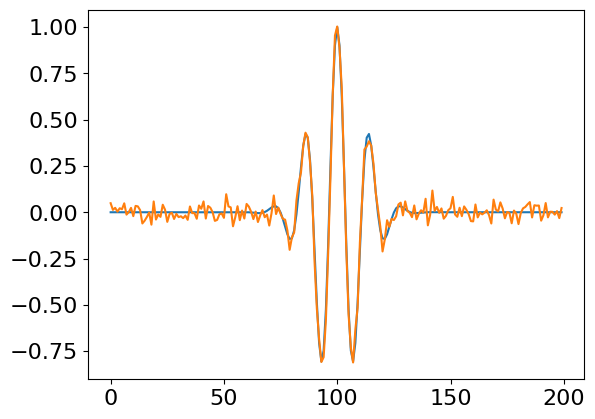

In [221]:
flatline = np.zeros_like(target)
flatline_score = np.linalg.norm((target -flatline) /uncertainties) #This is the chi-squared

narrowband = spfft.dct(target, type= 1)
narrowband[~(np.abs(narrowband) >= np.percentile(np.abs(narrowband), 98))] = 0 # delete most of the frequencies
narrowband = spfft.idct(narrowband, type= 1)
narrowband_score = np.linalg.norm((target -narrowband) /uncertainties) #This is the chi-squared

noiseless, _ = cs.open_dataset(training_file_name, file_type)
noiseless_score = np.linalg.norm((target -noiseless) /uncertainties) #This is the chi-squared

plt.plot(noiseless)
plt.plot(target)
plt.show()

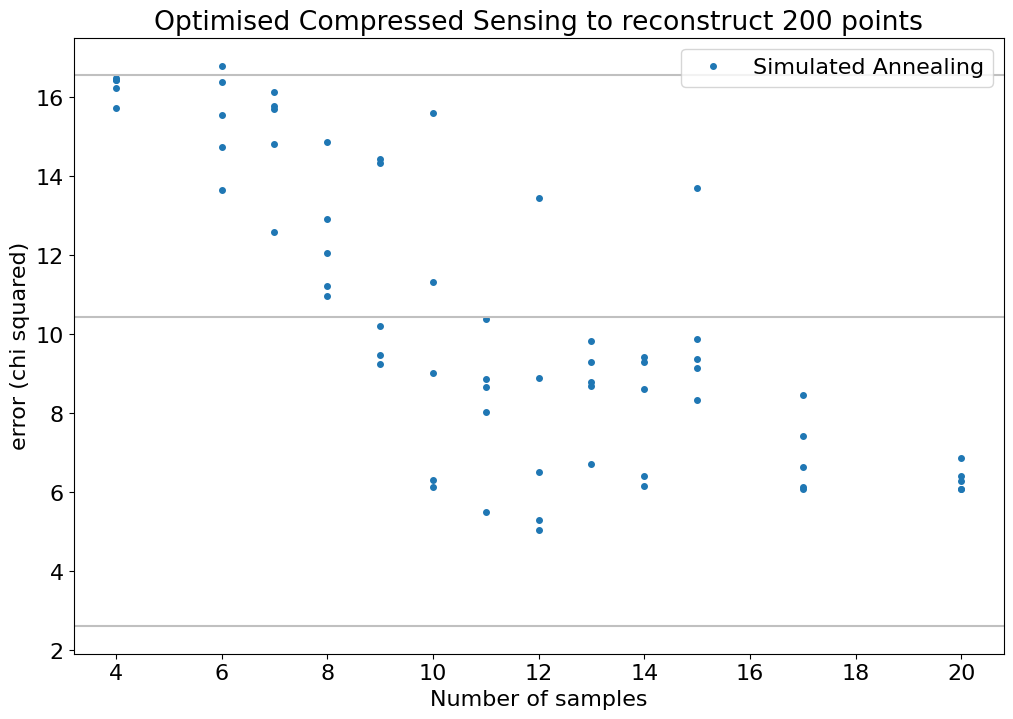

In [222]:
fig, axs = plt.subplots(figsize= (12,8))

axs.plot(reduced_points, best_scores["Simulated Annealing"], linestyle= "None", marker= ".", markersize= 8, label= "Simulated Annealing")
#axs.plot(reduced_points, best_scores["MCMC Metropolis"], linestyle= "None", marker= ".", markersize= 8, label= "MCMC Metropolis")

axs.hlines([flatline_score, narrowband_score, noiseless_score], 0, 1, colors= "silver", transform= axs.get_yaxis_transform())

axs.set(xlabel= "Number of samples",
        ylabel= "error (chi squared)",
        title= "Optimised Compressed Sensing to reconstruct {0:d} points".format(total_point))

axs.legend()

plt.show()

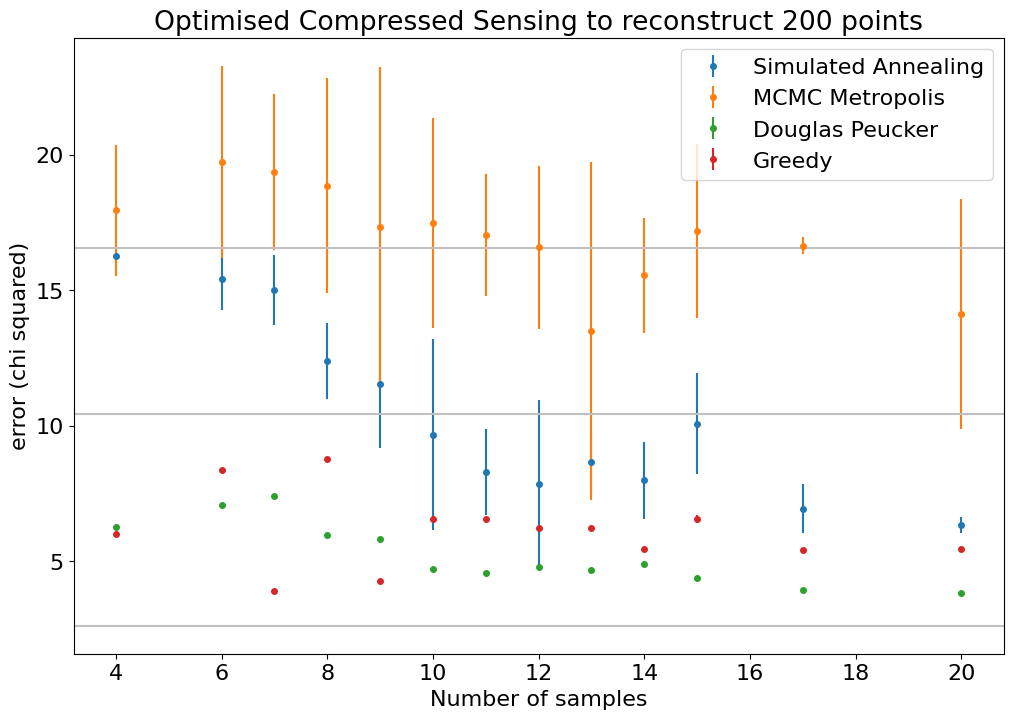

In [223]:
fig, axs = plt.subplots(figsize= (12,8))

for method in best_scores.keys():
        axs.errorbar(unique_reduced_points, mean_score[method], yerr= std_score[method], linestyle= "None", marker= ".", markersize= 8, label= method)

axs.hlines([flatline_score, narrowband_score, noiseless_score], 0, 1, colors= "silver", transform= axs.get_yaxis_transform())

axs.set(xlabel= "Number of samples",
        ylabel= "error (chi squared)",
        title= "Optimised Compressed Sensing to reconstruct {0:d} points".format(total_point))


#axs.grid(True)
axs.legend()

plt.show()

In [225]:
best_configurations["MCMC Metropolis"]

[array([ 90, 132, 137, 199]),
 array([ 39,  89, 118, 196]),
 array([ 37, 170, 182, 197]),
 array([ 30,  55,  98, 173]),
 array([ 44,  60, 149, 185]),
 array([ 28,  33,  40, 134, 145, 177]),
 array([ 96, 101, 111, 125, 127, 155]),
 array([ 30,  41, 100, 168, 185, 197]),
 array([ 43,  75, 127, 132, 151, 167]),
 array([ 42,  56,  74,  87, 168, 176]),
 array([ 38,  51,  60,  64,  79, 106, 145]),
 array([ 19,  33,  35,  53,  69, 101, 177]),
 array([  3,  56,  58,  85, 130, 152, 191]),
 array([ 17,  18,  67, 111, 166, 181, 189]),
 array([  4,  77,  94, 102, 150, 162, 164]),
 array([ 34,  51,  73,  96,  97, 153, 190, 196]),
 array([  2,   6,  16,  60,  71, 123, 152, 158]),
 array([  6,  30,  63,  92, 125, 156, 170, 182]),
 array([ 15,  34,  44, 100, 136, 144, 157, 172]),
 array([ 30,  58,  75, 153, 174, 178, 184, 188]),
 array([ 58,  78,  81,  84,  99, 100, 147, 156, 165]),
 array([  6,  41, 108, 112, 136, 144, 157, 163, 199]),
 array([ 11,  17,  31,  47, 120, 124, 140, 164, 174]),
 array([ 2

In [227]:
best_configurations["Simulated Annealing"]

[array([  9,  53, 121, 175]),
 array([ 11,  78, 131, 189]),
 array([  3,  77, 123, 196]),
 array([ 11,  78, 138, 195]),
 array([  3,  77, 123, 196]),
 array([  3,  39,  85, 116, 157, 196]),
 array([  4,  39,  78, 121, 160, 195]),
 array([  2,  32,  93, 116, 151, 196]),
 array([  5,  31,  79, 127, 156, 195]),
 array([ 11,  50,  79, 121, 163, 195]),
 array([  3,  27,  58, 108, 143, 171, 196]),
 array([  3,  36,  62, 107, 134, 164, 195]),
 array([ 29,  37,  53, 107, 112, 177, 194]),
 array([  3,  43,  60, 114, 127, 154, 197]),
 array([  4,  32,  55,  91, 139, 142, 196]),
 array([  9,  22,  61,  93, 115, 142, 181, 196]),
 array([  4,  16,  54,  93, 115, 141, 168, 197]),
 array([  4,  22,  59,  80, 112, 144, 176, 183]),
 array([ 17,  31,  53,  93, 116, 142, 168, 196]),
 array([  2,  22,  71,  93, 115, 146, 172, 198]),
 array([  4,  33,  39,  71, 107, 113, 139, 176, 191]),
 array([  9,  15,  68,  71, 107, 113, 149, 162, 194]),
 array([  2,  18,  50,  66,  92, 127, 153, 179, 196]),
 array([  

In [ ]:
#array = np.array([np.round(subsample_percentages *total_point), best_scores]).T
#np.savetxt("data\\error2samples{:d}.csv".format(file_number), array, delimiter=',', header="no of samples, error")